In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import math

This notebook contains analysis of class imbalance handling methods (Weighted CE vs Focal Loss), results analysis of our baseline and challenger models, as well as explainability ML of our best performing model.

## WCE vs Focal Loss 

In [69]:
wce_results = pd.read_csv('./results/comparison_20251117_231431.csv')
focal_results = pd.read_csv('./results/focal_experiments_20251117_083217.csv')

In [79]:
wce_filtered = wce_results[
    (wce_results['Configuration'].isin(['baseline_noweight', 'baseline_weight'])) &
    (wce_results['Model'].isin(['gcn', 'graphsage']))]
wce_filtered.columns = wce_filtered.columns.str.lower()
wce_filtered = wce_filtered.rename(columns={'configuration': 'experiment'})

focal_filtered = focal_results[
    focal_results['experiment'].isin(['gcn_baseline_focal', 'graphsage_baseline_focal'])]
common_cols = list(set(wce_filtered.columns) & set(focal_filtered.columns))

wce_common = wce_filtered[common_cols]
focal_common = focal_filtered[common_cols]

prelim_results = pd.concat([wce_common, focal_common], axis=0, ignore_index=True)
prelim_results

,training_time,model,fn,recall,experiment,tn,tp,precision,f1,fp
0,270.911620,graphsage,235,0.424020,baseline_weight,8338,173,0.645522,0.511834,95
1,321.439599,gcn,244,0.401961,baseline_weight,8338,164,0.633205,0.491754,95
2,214.993063,graphsage,266,0.348039,baseline_noweight,8421,142,0.922078,0.505338,12
3,361.686362,gcn,293,0.281863,baseline_noweight,8412,115,0.845588,0.422794,21
4,4.879084,graphsage,294,0.279412,graphsage_baseline_focal,8418,114,0.883721,0.424581,15
5,5.037795,gcn,318,0.220588,gcn_baseline_focal,8422,90,0.891089,0.353635,11


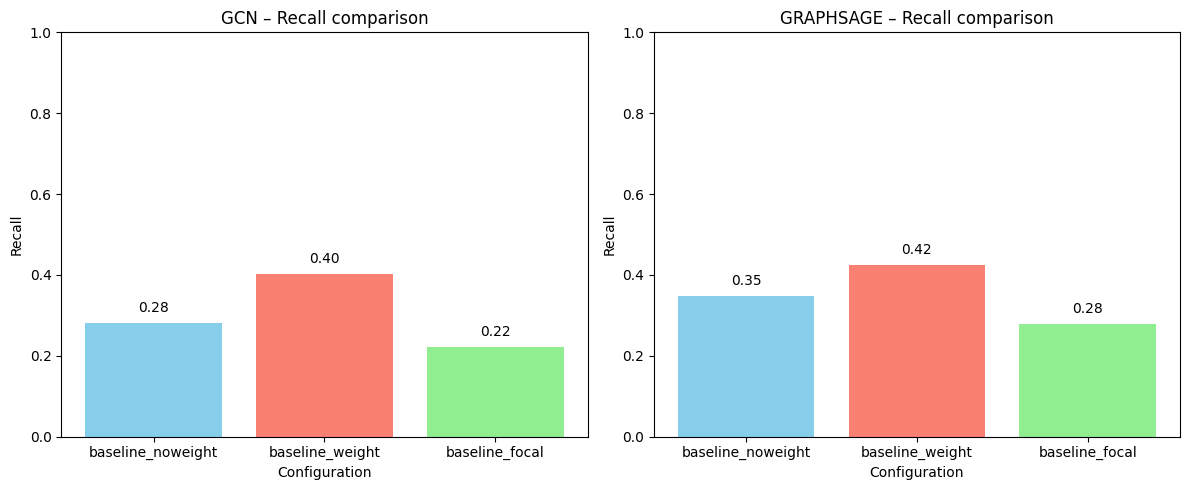

In [85]:
prelim_results['configuration'] = prelim_results['experiment'].replace({
    'gcn_baseline_focal': 'baseline_focal',
    'graphsage_baseline_focal': 'baseline_focal'
})

models = ['gcn', 'graphsage']
metric = 'recall'

color_map = {
    'baseline_noweight': 'skyblue',
    'baseline_weight': 'salmon',
    'baseline_focal': 'lightgreen'}

plt.figure(figsize=(12, 5))

for i, model in enumerate(models, 1):

    d = prelim_results[prelim_results['model'] == model].copy()
    order = ['baseline_noweight', 'baseline_weight', 'baseline_focal']
    d = d.set_index('configuration').loc[order].reset_index()
    bar_colors = [color_map[c] for c in d['configuration']]

    plt.subplot(1, 2, i)
    bars = plt.bar(d['configuration'], d[metric], color=bar_colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,  
            height + 0.02,                   
            f"{height:.2f}",                  
            ha='center', va='bottom', fontsize=10)

    plt.title(f"{model.upper()} – {metric.capitalize()} comparison", fontsize=12)
    plt.xlabel("Configuration")
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.grid(False)

plt.tight_layout()
plt.show()

## Results analysis

In [3]:
results = pd.read_csv('./tables/selected_models_metrics_summary.csv')
results

,model,precision,recall,f1,auc_roc,auc_pr,tn,fp,fn,tp,best_val_f1,training_time
0,xgb_engineered_weight_tuned,0.8511,0.4902,0.6221,0.9380,0.6529,8398,35,208,200,NaN,NaN
1,xgb_engineered_weight,0.7398,0.4877,0.5879,0.8544,0.5617,8363,70,209,199,NaN,1.8503
2,ensemble_graphsage_xgb_engineered_weight,0.8525,0.4534,0.5920,0.8505,0.5495,8401,32,223,185,NaN,NaN
3,graphsage_engineered_weight,0.7020,0.4216,0.5268,0.8288,0.4878,8360,73,236,172,0.7888,176.6862
4,gcn_engineered_weight,0.3767,0.4118,0.3934,0.8294,0.3991,8155,278,240,168,0.7383,188.7707
5,gcn_baseline_weight,0.6000,0.3456,0.4386,0.8242,0.4454,8339,94,267,141,0.6815,100.8818


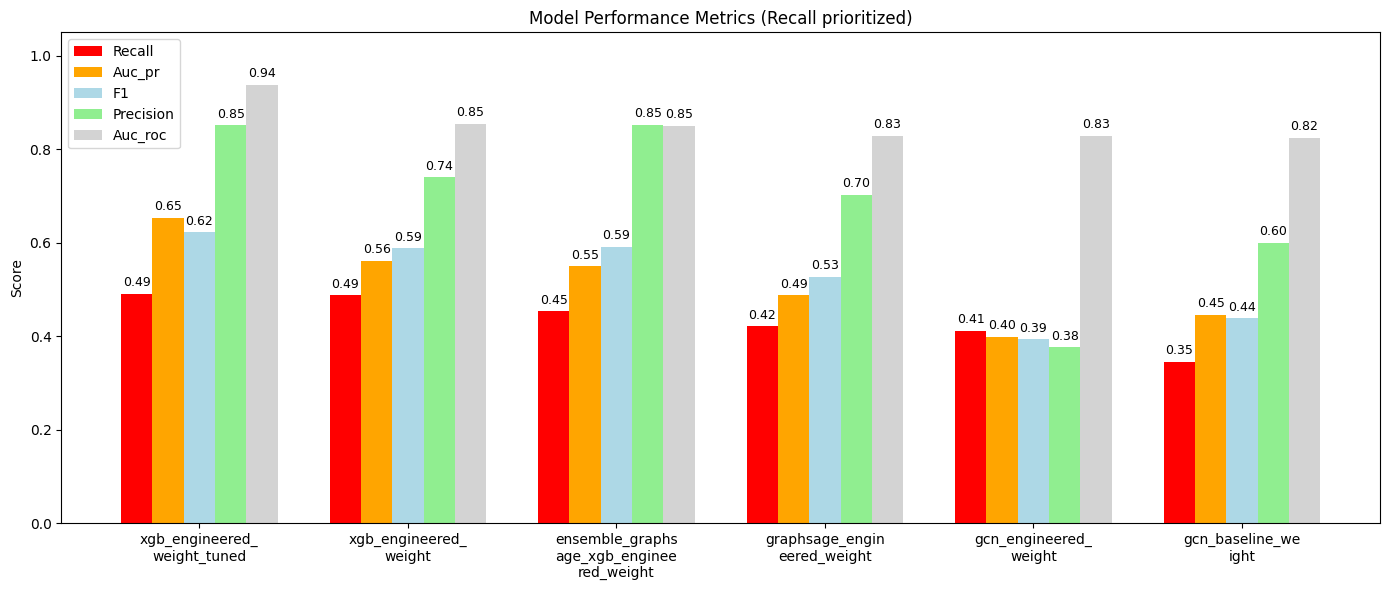

In [4]:
def wrap_label(label, width=20):
    return '\n'.join(textwrap.wrap(label, width))

results['model_wrapped'] = results['model'].apply(lambda x: wrap_label(x, width=15))

metrics = ['recall','auc_pr','f1','precision','auc_roc']
colors = ['red','orange','lightblue','lightgreen','lightgray']

x = np.arange(len(results['model']))
width = 0.15

plt.figure(figsize=(14,6))

for i, metric in enumerate(metrics):
    bars = plt.bar(x + i*width, results[metric], width, label=metric.capitalize(), color=colors[i])
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, height + 0.01, 
            f'{height:.2f}', ha='center', va='bottom', fontsize=9
        )

plt.xticks(x + width*2, results['model_wrapped'], rotation=0, ha='center')  
plt.ylabel('Score')
plt.ylim(0,1.05)
plt.title('Model Performance Metrics (Recall prioritized)')
plt.legend()
plt.tight_layout()
plt.show()


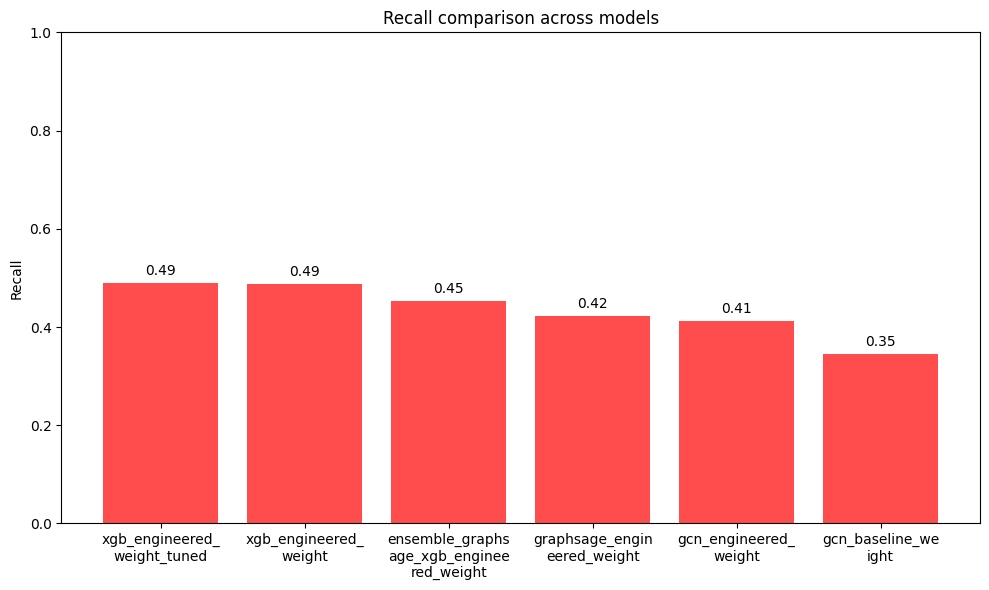

In [5]:
def wrap_label(label, width=20):
    return '\n'.join(textwrap.wrap(label, width))

results['model_wrapped'] = results['model'].apply(lambda x: wrap_label(x, width=15))

plt.figure(figsize=(10,6))
bars = plt.bar(results['model_wrapped'], results['recall'], color='red', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.01, 
        f'{height:.2f}', ha='center', va='bottom', fontsize=10
    )

plt.ylabel('Recall')
plt.ylim(0, 1)
plt.title('Recall comparison across models')
plt.xticks(rotation=0, ha='center') 
plt.tight_layout()
plt.show()

## Confusion matrix

In [6]:
df_cm = pd.read_csv('./tables/selected_models_confusion_matrices.csv')
df_cm

,model,PredP_ActP_TP,PredP_ActN_FP,PredN_ActP_FN,PredN_ActN_TN
0,xgb_engineered_weight_tuned,200,35,208,8398
1,xgb_engineered_weight,199,70,209,8363
2,ensemble_graphsage_xgb_engineered_weight,185,32,223,8401
3,graphsage_engineered_weight,172,73,236,8360
4,gcn_engineered_weight,168,278,240,8155
5,gcn_baseline_weight,141,94,267,8339


In [7]:
for _, row in df_cm.iterrows():
    print(f"\nModel: {row['model']}")
    cm = [[row['PredP_ActP_TP'], row['PredP_ActN_FP']],
          [row['PredN_ActP_FN'], row['PredN_ActN_TN']]]
    print(pd.DataFrame(cm, index=['Actual Positive', 'Actual Negative'],
                             columns=['Predicted Positive', 'Predicted Negative']))


Model: xgb_engineered_weight_tuned
                 Predicted Positive  Predicted Negative
Actual Positive                 200                  35
Actual Negative                 208                8398

Model: xgb_engineered_weight
                 Predicted Positive  Predicted Negative
Actual Positive                 199                  70
Actual Negative                 209                8363

Model: ensemble_graphsage_xgb_engineered_weight
                 Predicted Positive  Predicted Negative
Actual Positive                 185                  32
Actual Negative                 223                8401

Model: graphsage_engineered_weight
                 Predicted Positive  Predicted Negative
Actual Positive                 172                  73
Actual Negative                 236                8360

Model: gcn_engineered_weight
                 Predicted Positive  Predicted Negative
Actual Positive                 168                 278
Actual Negative                 240

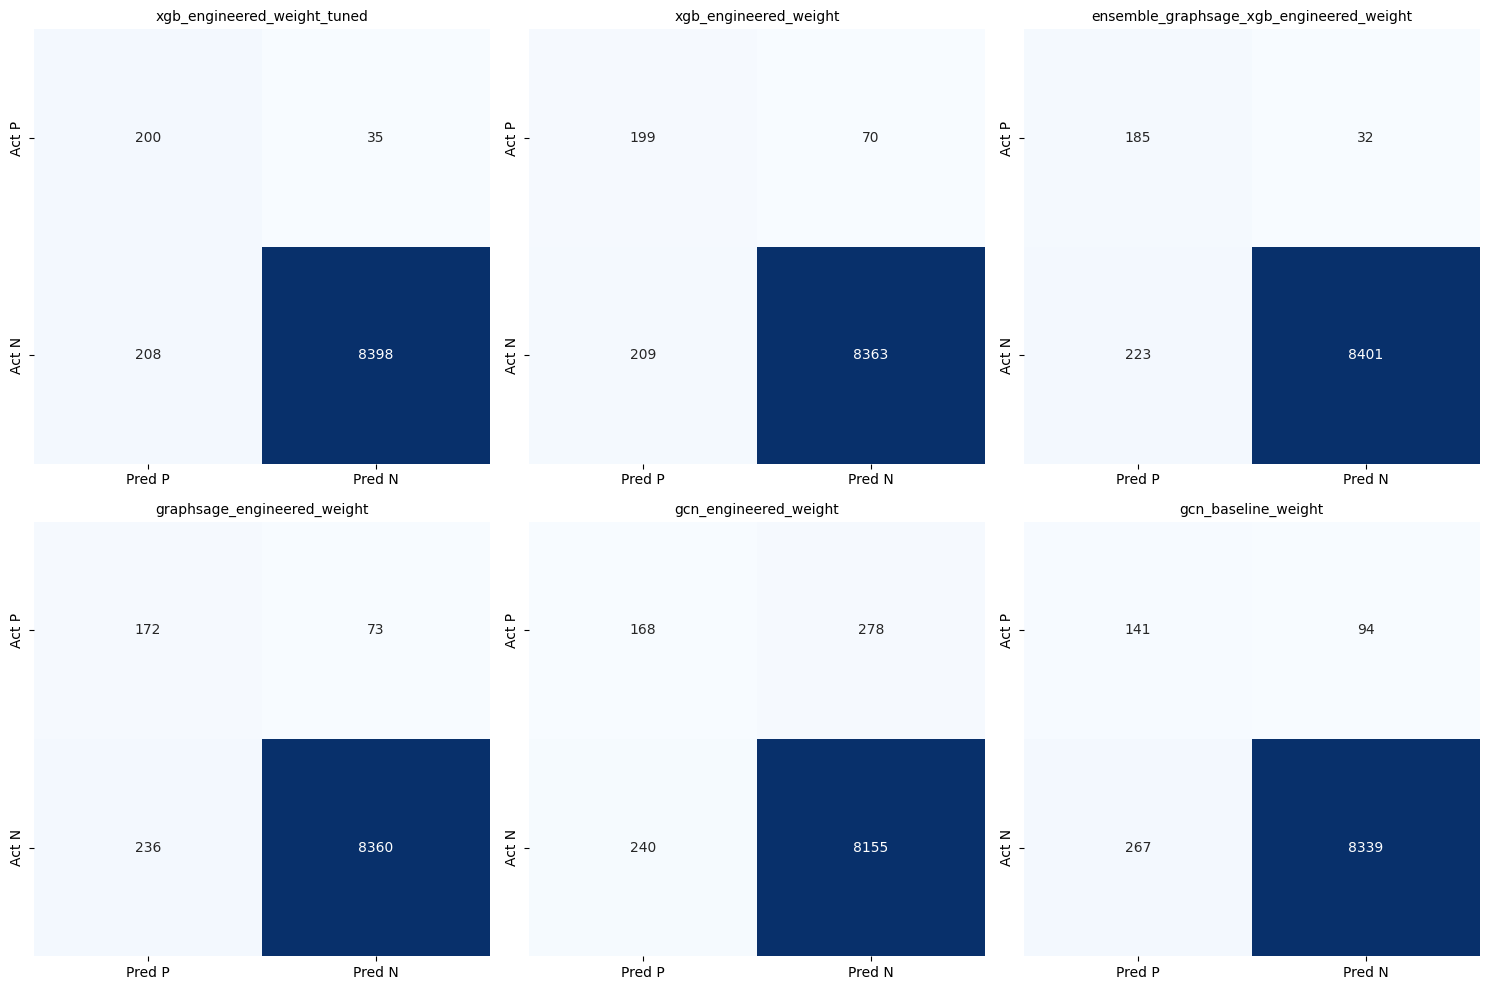

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (_, row) in enumerate(df_cm.iterrows()):
    cm = [
        [row['PredP_ActP_TP'], row['PredP_ActN_FP']],
        [row['PredN_ActP_FN'], row['PredN_ActN_TN']]
    ]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred P', 'Pred N'],
                yticklabels=['Act P', 'Act N'],
                ax=axes[i])
    axes[i].set_title(row['model'], fontsize=10)

# Turn off any unused subplot (last one in this case)
if len(df_cm) < len(axes):
    for j in range(len(df_cm), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

## Explainability

In [64]:
import sys
print(sys.version)

3.9.23 (main, Sep  2 2025, 13:00:56) 
[Clang 17.0.0 (clang-1700.0.13.5)]


In [38]:
import os
import pickle
import random
import shap
import warnings
warnings.filterwarnings("ignore")

# Custom modules
from data_loader import EllipticDataLoader
from feature_eng import FeatureEngineer

# Ensure inline plotting
%matplotlib inline

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [41]:
MODEL_PATH = "models/xgboost_engineered_weight_tuned.pkl"

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Could not find {MODEL_PATH}. Please train and save the tuned XGBoost model first.")

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

print("Loaded tuned model from:", MODEL_PATH)

Loaded tuned model from: models/xgboost_engineered_weight_tuned.pkl


In [42]:
loader = EllipticDataLoader(data_dir="data")
xgb_data = loader.get_feature_matrix_for_xgboost(use_engineered=True)

X_train = xgb_data["X_train"]
y_train = xgb_data["y_train"]
X_test  = xgb_data["X_test"]
y_test  = xgb_data["y_test"]

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

Loading raw data...
Adding engineered features...
Added 12 features
Illicit transactions with equal splits: 65.9%
Licit transactions with equal splits: 8.8%
XGBoost using 194 features (including engineered)
X_train shape: (29894, 194)
X_test  shape: (8841, 194)


In [43]:
# Load raw data
tx_features, tx_classes, _, addr_tx_in, tx_addr_out = loader.load_raw_data()
engineer = FeatureEngineer("data")
df_eng, eng_features = engineer.engineer_features(tx_features, tx_classes, addr_tx_in, tx_addr_out)

exclude_cols = ['txId', 'Time step', 'time_step', 'class', 'label', 'out_range_ratio']
feature_cols = [c for c in df_eng.columns if c not in exclude_cols]

numeric_feature_cols = df_eng[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_names = numeric_feature_cols

assert X_train.shape[1] == len(feature_names), "Feature count mismatch!"

print("Number of engineered+baseline features:", len(feature_names))

Loading raw data...
Adding engineered features...
Added 12 features
Illicit transactions with equal splits: 65.9%
Licit transactions with equal splits: 8.8%
Number of engineered+baseline features: 194


In [44]:
# Random subset as background
background_size = min(10000, X_train.shape[0])
background_idx = np.random.choice(X_train.shape[0], size=background_size, replace=False)
background = X_train[background_idx]

print("Background size for SHAP:", background.shape[0])

explainer = shap.TreeExplainer(model, data=background)
shap_values = explainer.shap_values(X_test)

# Handle list output for XGBoost multiclass compatibility
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
print("SHAP values shape:", np.array(shap_vals).shape)

Background size for SHAP: 10000


100%|===================| 8811/8841 [01:09<00:00]        

SHAP values shape: (8841, 194)


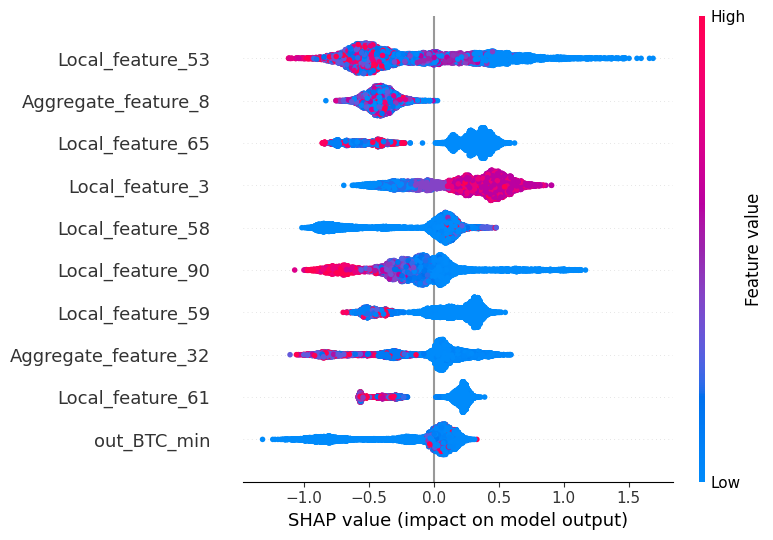

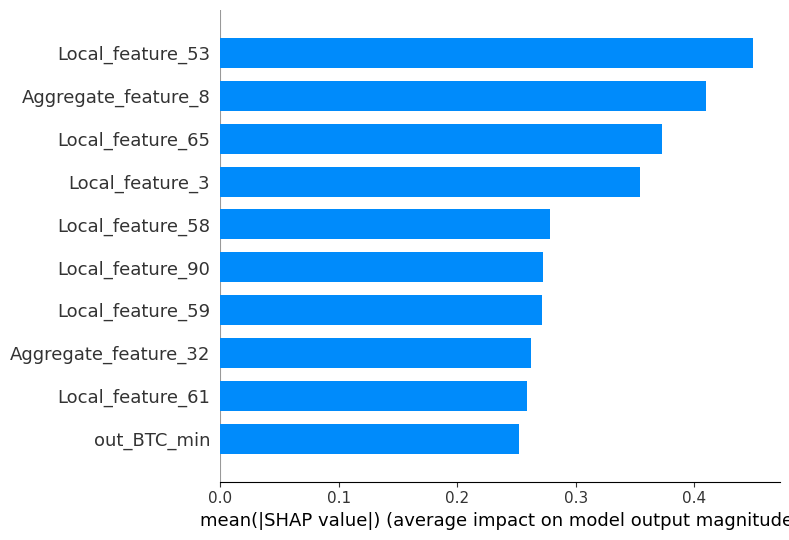

In [50]:
# Create results folder
os.makedirs("results", exist_ok=True)

# Beeswarm summary
shap.summary_plot(shap_vals, X_test, feature_names=feature_names, max_display=10)

# Bar plot
shap.summary_plot(shap_vals, X_test, feature_names=feature_names, plot_type="bar", max_display=10)

**SHAP Plot**\
Positive values (right): Push prediction towards illicit\
Negative values (left): Push prediction towards licit

- Local_feature_53: low feature value can better predict illicit transactions 
- Aggregate_feature_8: mix of low and high feature value in predicting licit transactions; feature has weak effect
- Local_feature_65: low feature value in prediciting illicit transactions, mix of low and high feature value in predicting licit transactions 
- Local_feature_3: high feature value in predicting illicit and low feature value in prediciting licit -> clear pattern 
- Remaining features: generally low feature values in predicting fraud; may represent local neighbourhood structural properties
- out_BTC_min: some red dots on the right -> high-value transactions occasionally drive fraud risk

Fraud patterns identified:
- Generally, low values push towards fraud which is consistent with some illicit patterns such as smurfing, peel-chain behvaiour where BTC is split into small amounts 
- Local_feature_3 shows high feature values predict illicit transactions better; Local_feature_53 and a bit of out_BTC_min shows that some high values also predicts illicit transactions
- In general, the model relies more on local and aggregate graph features

The plot shows how non-linear patterns work better and there is some sort of U-shaped relationships (both extremes work to predict fraud), which may be a reason why GNNs struggle with these non-linear patterns while tree-based models (XGBoost) works better at this. Local features also dominate more. 

In [46]:
# Mean absolute SHAP
mean_abs_shap = np.mean(np.abs(shap_vals), axis=0)

feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# Save full ranking
feature_importance_df.to_csv("results/shap_feature_ranking_xgb_tuned.csv", index=False)

# Top 30 features
top_30 = feature_importance_df.head(30)
top_30.to_csv("results/shap_top30_xgb_tuned.csv", index=False)

# Bottom 30 features
bottom_30 = feature_importance_df.tail(30)
bottom_30.to_csv("results/shap_bottom30_xgb_tuned.csv", index=False)

print("Top 10 features:\n", top_30.head(10))
print("\nBottom 10 features:\n", bottom_30.tail(10))

# Cumulative 95% importance
total_importance = feature_importance_df["mean_abs_shap"].sum()
feature_importance_df["rel_importance"] = feature_importance_df["mean_abs_shap"] / total_importance
feature_importance_df["cumulative_importance"] = feature_importance_df["rel_importance"].cumsum()

selected_df = feature_importance_df[feature_importance_df["cumulative_importance"] <= 0.95]
if selected_df.empty:
    selected_df = feature_importance_df.iloc[[0]]

selected_df.to_csv("results/shap_selected95_xgb_tuned.csv", index=False)

print(f"\nSelected {len(selected_df)} features explaining 95% of SHAP importance.")
print(selected_df.head(10))

Top 10 features:
                 feature  mean_abs_shap
0      Local_feature_53       0.449899
1   Aggregate_feature_8       0.410127
2      Local_feature_65       0.373169
3       Local_feature_3       0.353964
4      Local_feature_58       0.278334
5      Local_feature_90       0.272612
6      Local_feature_59       0.271903
7  Aggregate_feature_32       0.262024
8      Local_feature_61       0.258633
9           out_BTC_min       0.252046

Bottom 10 features:
                 feature  mean_abs_shap
184    Local_feature_38       0.000267
185     peel_chain_flag       0.000000
186    Local_feature_63       0.000000
187    Local_feature_75       0.000000
188  small_outputs_flag       0.000000
189   many_outputs_flag       0.000000
190    Local_feature_15       0.000000
191     Local_feature_7       0.000000
192    Local_feature_69       0.000000
193             fan_out       0.000000

Selected 123 features explaining 95% of SHAP importance.
                feature  mean_abs_shap  rel_

## EDA on dataset

In [51]:
# Load data
# Transaction-level data
addr_tx_in = pd.read_csv("./data/AddrTx_edgelist.csv")
tx_addr_out = pd.read_csv("./data/TxAddr_edgelist.csv")

tx_features = pd.read_csv("./data/txs_features.csv")
tx_classes = pd.read_csv("./data/txs_classes.csv")
tx_edges = pd.read_csv("./data/txs_edgelist.csv")

In [52]:
# Data Preprocessing
# Merge tx features + classes (labels) and rename columns for accessibility
tx_df = tx_features.merge(tx_classes, on="txId", how="left")
tx_df["class_mapped"] = tx_df["class"].replace({1: "illicit", 2: "licit", 3: "unknown"})
tx_df = tx_df.rename(columns={"txId": "tx_id", "Time step": "time_step"})

addr_tx_in = addr_tx_in.rename(columns={'txId': 'tx_id', 'input_address': 'address'})
tx_addr_out = tx_addr_out.rename(columns={'txId': 'tx_id', 'output_address': 'address'})

In [53]:
top_features = [
    "Local_feature_53",
    "Aggregate_feature_8",
    "Local_feature_65",
    "Local_feature_3",
    "Local_feature_90",
    "Local_feature_59",
    "Local_feature_61",
    "Aggregate_feature_32",
    "out_BTC_min",
]

In [54]:
existing_top_features = [f for f in top_features if f in tx_df.columns]

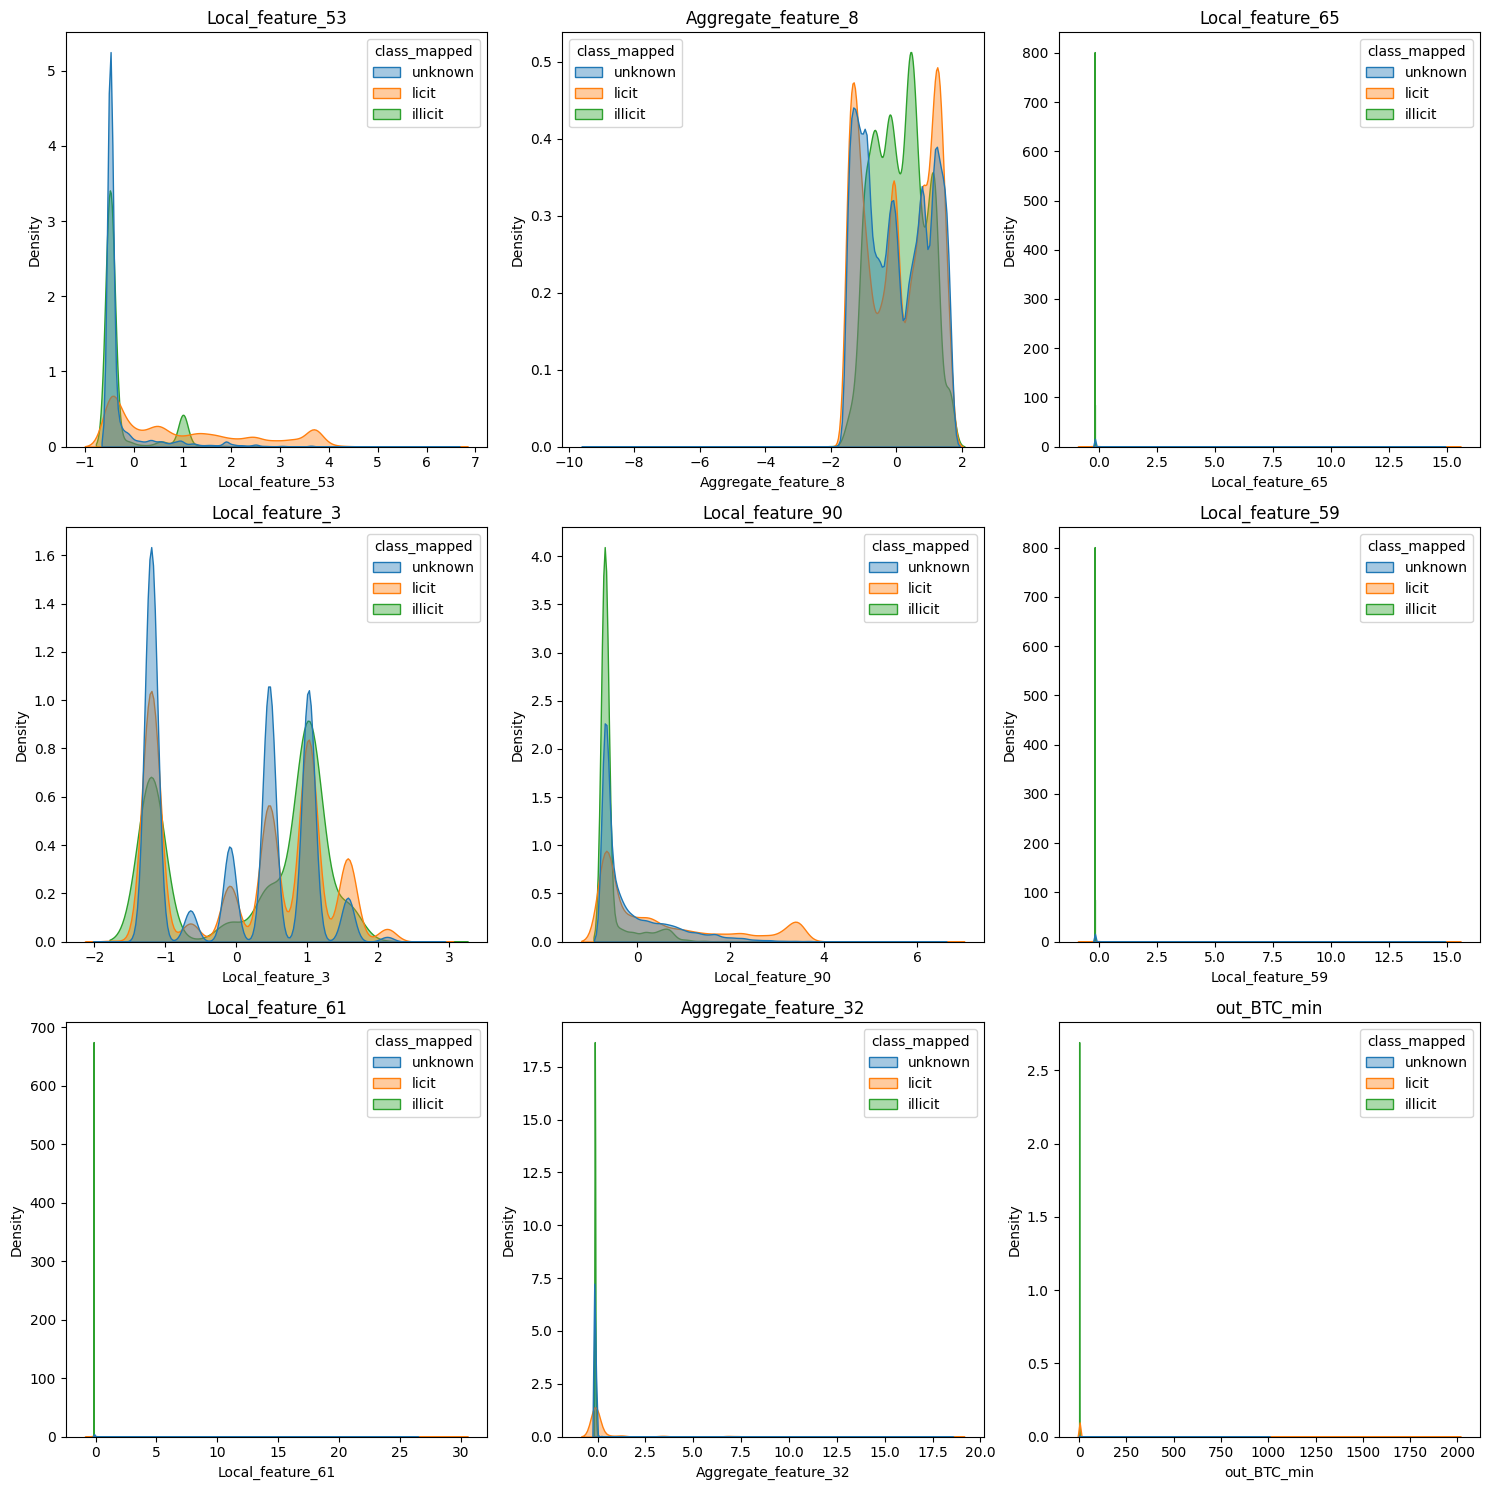

In [58]:
n = len(existing_top_features)
rows = math.ceil(n / 3)

plt.figure(figsize=(15, 5*rows))

for i, col in enumerate(existing_top_features, 1):
    plt.subplot(rows, 3, i)
    sns.kdeplot(
        data=tx_df,
        x=col,
        hue="class_mapped",
        common_norm=False,
        fill=True,
        alpha=0.4
    )
    plt.title(col)

plt.tight_layout()
plt.show()